# Module Definition

In [3]:
# plt 의 한글 출력을 위한 설정

import pandas as pd
import numpy as np
import statsmodels
import matplotlib.pyplot as plt
import scipy.stats

from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

from scipy import stats

# 데이터 출력
df = pd.read_excel('./Stat_Aggregate.xlsx',header = 0 )

# 결과를 담을 df_result 파일 새로 생성 
df_result = df.copy()

df.head(3)

,지표 구분,지표 정의,지표 상세,A_분자,B_분자,C_분자,A_분모,B_분모,C_분모,A_분산,B_분산,C_분산
0,conversion,구매 전환율,미식선물 컬렉션 구매자수 / 미식선물 컬렉션 노출 사용자수,49,59,78,272394,281384,268483,NaN,NaN,NaN
1,continuous,유저당 주문수,미식선물 컬렉션 주문수 / 미식선물 컬렉션 노출 사용자수,50,66,86,272394,281384,268483,2.041000e-02,1.753400e-01,1.711600e-01
2,continuous,유저당 거래액,미식선물 컬렉션 거래액 / 미식선물 컬렉션 노출 사용자수,1165100,1585960,2067400,272394,281384,268483,7.935969e+07,1.935180e+08,2.163052e+08


In [6]:
def plot_ci(dataset,name):
    """
    Parameters 
    ----------
    dataset : 데이터
    
    Resturns
    --------
    None : plot 파일을 세이브하고, 이를 plotting 함

    Example 
    -------
    from matplotlib import pyplot as plt
    data_dict = {}
    data_dict['category'] = ['category 1','category 2','category 3']
    data_dict['lower'] = [0.1,0.2,0.15]
    data_dict['mean'] = [0.16,0.25,0.18]
    data_dict['upper'] = [0.22,0.3,0.21]
    dataset = pd.DataFrame(data_dict)
    plot_ci(dataset,'Metric_Name')
    """
    print(dataset)
    plt.figure(figsize = (10,2))
    for lower,mean,upper,y in zip(dataset['lower'],
                                dataset['mean'],
                                dataset['upper'],
                                range(len(dataset))):
        # (lower , y) 와 (upper , y ) 를 잇는 선을 만들어냅니다. 즉 가로 수직선이 됩니다. 
        plt.plot((lower,upper),(y,y),'|-',color = 'blue')
        plt.plot(mean,y,'o',color = 'blue')
    plt.yticks([-1]+list(range(len(dataset)))+[len(dataset)],[''] + list(dataset['category']) + [''])
    # 0 위치 표시하기 
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
    plt.title(name)
    plt.show()


In [ ]:
data_dict = {}
data_dict['category'] = ['category 1','category 2','category 3']
data_dict['lower'] = [0.1,0.2,0.15]
data_dict['mean'] = [0.16,0.25,0.18]
data_dict['upper'] = [0.22,0.3,0.21]

     category  lower  mean  upper
0  category 1   0.10  0.16   0.22
1  category 2   0.20  0.25   0.30
2  category 3   0.15  0.18   0.21


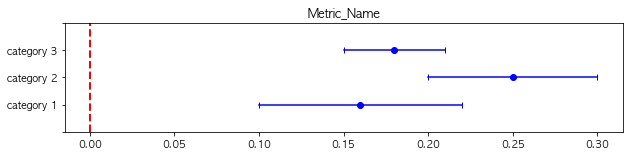

In [7]:
from matplotlib import pyplot as plt
data_dict = {}
data_dict['category'] = ['category 1','category 2','category 3']
data_dict['lower'] = [0.1,0.2,0.15]
data_dict['mean'] = [0.16,0.25,0.18]
data_dict['upper'] = [0.22,0.3,0.21]
dataset = pd.DataFrame(data_dict)
plot_ci(dataset,'Metric_Name')

# Proportion Test : 구현

- 테스트 통계량 
    - $Z=\frac{\left(\hat{p}_{X}-\hat{p}_{Y}\right)}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n}+\frac{1}{m}\right)}}$
- $(1-\alpha) \times 100 \%$ confidence interval for $p$
    - $\left(\hat{p}-z_{1-\alpha / 2} \sqrt{\hat{p}(1-\hat{p}) / n}, \hat{p}+z_{1-\alpha / 2} \sqrt{\hat{p}(1-\hat{p}) / n}\right)$

In [6]:
def two_proprotions_test(success_a, size_a, success_b, size_b):
    """ proportion 에 대해서 AB 테스트를 진행합니다. (two sided)
    Parameters
    ----------
    success_a, success_b (int) : Number of successes in each group
    size_a, size_b (int) : Size, or number of observations in each group
    
    Returns
    -------
    zscore (float) :test statistic for the two proportion z-test
    pvalue (float) : p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

In [7]:
def two_proprotions_confint(success_a, size_a, success_b, size_b, significance = 0.05):
    """ AB Test 를 수행합니다. 
    Parameters
    ----------
    success_a, success_b (int) : 각 그룹의 success number 
    size_a, size_b (int) : 각 그룹의 전체 sample 수 
    significance (float) : 유의수준 

    Returns
    -------
    confint : Confidence interval 과 mean 을 출력. 즉 [lower , mean , upper]
    """

    prop_a = success_a / size_a
    prop_b = success_b / size_b
    var = prop_a * (1 - prop_a) / size_a + prop_b * (1 - prop_b) / size_b
    se = np.sqrt(var)
    # z critical value
    z = stats.norm(loc = 0, scale = 1).ppf(1- significance / 2)

    # standard formula for the confidence interval
    # point-estimtate +- z * standard-error
    prop_diff = prop_b - prop_a
    confint = prop_diff + np.array([-1,0, 1]) * z * se
    return confint

# Mean Test 구현

- $\frac{(\bar{X}-\bar{Y})-\left(\mu_{X}-\mu_{Y}\right)}{\sqrt{\frac{\sigma_{X}^{2}}{n}+\frac{\sigma_{Y}^{2}}{m}}} \sim N(0,1)$
- $(1-\alpha) \times 100 \%$ confidence interval for $\mu_{1}-\mu_{2}$
$$
\left((\bar{x}-\bar{y})-z_{1-\alpha / 2} \sqrt{\frac{s_{1}^{2}}{n_{1}}+\frac{s_{2}^{2}}{n_{2}}},(\bar{x}-\bar{y})+z_{1-\alpha / 2} \sqrt{\frac{s_{1}^{2}}{n_{1}}+\frac{s_{2}^{2}}{n_{2}}}\right)
$$

In [14]:
def two_mean_test(mean_A,var_A,size_A,mean_B,var_B,size_B,alpha = 0.05) :
    std_A = np.sqrt(var_A)
    std_B = np.sqrt(var_B)
    SE = np.sqrt(std_A**2/size_A + std_B**2/size_B)
    Z = (mean_B - mean_A) / SE
    p_val = 2*scipy.stats.norm.cdf(-1*abs(Z))
    z_a = scipy.stats.norm.ppf(1 - alpha/2)
    CI = [(mean_B-mean_A) - z_a*SE , mean_B - mean_A , (mean_B-mean_A) + z_a*SE]
    return Z , p_val, CI

In [19]:
def continuous_inference(idx) : 
    z_score, pval , CI = two_mean_test(df.loc[idx,'A_분자']/df.loc[idx,'A_분모'],
                                       df.loc[idx,'A_분산'],
                                       df.loc[idx,'A_분모'],
                                       df.loc[idx,'B_분자']/df.loc[idx,'B_분모'],
                                       df.loc[idx,'B_분산'],
                                       df.loc[idx,'B_분모'])
    lower, mean , upper = CI 
    df_result.loc[idx,'AB_mean'] = mean
    df_result.loc[idx,'AB_Z_통계량'] = round(z_score,4)
    df_result.loc[idx,'AB_P_value'] = round(pval,4)
    df_result.loc[idx,'AB_CI_Lower'] = lower
    df_result.loc[idx,'AB_CI_Upper'] = upper
    z_score, pval , CI = two_mean_test(df.loc[idx,'A_분자']/df.loc[idx,'A_분모'],
                                       df.loc[idx,'A_분산'],
                                       df.loc[idx,'A_분모'],
                                       df.loc[idx,'C_분자']/df.loc[idx,'C_분모'],
                                       df.loc[idx,'C_분산'],
                                       df.loc[idx,'C_분모'])
    lower, mean , upper = CI 
    df_result.loc[idx,'AC_mean'] = mean
    df_result.loc[idx,'AC_Z_통계량'] = round(z_score,4)
    df_result.loc[idx,'AC_P_value'] = round(pval,4)
    df_result.loc[idx,'AC_CI_Lower'] = lower
    df_result.loc[idx,'AC_CI_Upper'] = upper
    
    data_dict = {}
    data_dict['category'] = ['B의 효과 (B-A)','C의 효과 (C-A)']
    data_dict['lower'] = [df_result.loc[idx,'AB_CI_Lower'],
                        df_result.loc[idx,'AC_CI_Lower']]
    data_dict['mean'] = [df_result.loc[idx,'AB_mean'],
                        df_result.loc[idx,'AC_mean']]
    data_dict['upper'] = [df_result.loc[idx,'AB_CI_Upper'],
                        df_result.loc[idx,'AC_CI_Upper']]
    dataset = pd.DataFrame(data_dict)
    plot_ci(dataset[::-1],df_result.loc[idx,'지표 정의'])

In [20]:
def conversion_inference(idx): 
    z_score , pval = two_proprotions_test(df.loc[idx,'A_분자'],
                                        df.loc[idx,'A_분모'],
                                        df.loc[idx,'B_분자'],
                                        df.loc[idx,'B_분모'])
    lower , mean , upper = two_proprotions_confint(df.loc[idx,'A_분자'],
                                                df.loc[idx,'A_분모'],
                                                df.loc[idx,'B_분자'],
                                                df.loc[idx,'B_분모'])

    df_result.loc[idx,'AB_mean'] = mean
    df_result.loc[idx,'AB_Z_통계량'] = round(z_score,4) 
    df_result.loc[idx,'AB_P_value'] = round(pval,4)
    df_result.loc[idx,'AB_CI_Lower'] = lower
    df_result.loc[idx,'AB_CI_Upper'] = upper

    z_score , pval = two_proprotions_test(df.loc[idx,'A_분자'],
                                        df.loc[idx,'A_분모'],
                                        df.loc[idx,'C_분자'],
                                        df.loc[idx,'C_분모'])
    lower , mean , upper = two_proprotions_confint(df.loc[idx,'A_분자'],
                                                df.loc[idx,'A_분모'],
                                                df.loc[idx,'C_분자'],
                                                df.loc[idx,'C_분모'])

    df_result.loc[idx,'AC_mean'] = mean 
    df_result.loc[idx,'AC_Z_통계량'] = round(z_score,4)
    df_result.loc[idx,'AC_P_value'] = round(pval,4)
    df_result.loc[idx,'AC_CI_Lower'] = lower
    df_result.loc[idx,'AC_CI_Upper'] = upper

    data_dict = {}
    data_dict['category'] = ['B의 효과 (B-A)','C의 효과 (C-A)']
    data_dict['lower'] = [df_result.loc[idx,'AB_CI_Lower'],
                        df_result.loc[idx,'AC_CI_Lower']]
    data_dict['mean'] = [df_result.loc[idx,'AB_mean'],
                        df_result.loc[idx,'AC_mean']]
    data_dict['upper'] = [df_result.loc[idx,'AB_CI_Upper'],
                        df_result.loc[idx,'AC_CI_Upper']]
    dataset = pd.DataFrame(data_dict)
    plot_ci(dataset[::-1],df_result.loc[idx,'지표 정의'])

      category     lower      mean     upper
1  C의 효과 (C-A)  0.000029  0.000111  0.000192
0  B의 효과 (B-A) -0.000044  0.000030  0.000103


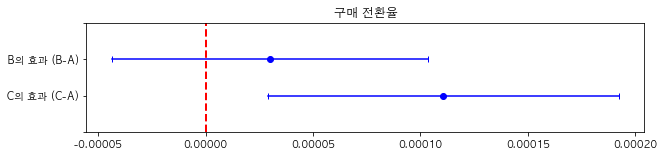

      category     lower      mean     upper
1  C의 효과 (C-A) -0.001518  0.000137  0.001791
0  B의 효과 (B-A) -0.001587  0.000051  0.001689


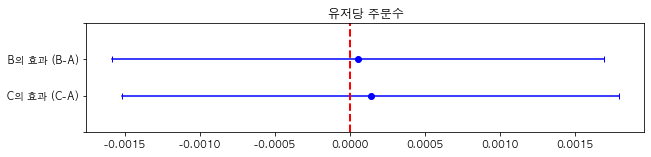

      category      lower      mean      upper
1  C의 효과 (C-A) -61.492860  3.423041  68.338942
0  B의 효과 (B-A) -59.968677  1.359023  62.686724


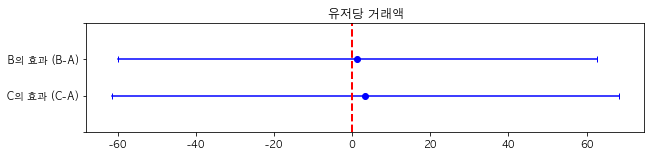

      category     lower      mean     upper
1  C의 효과 (C-A)  0.001681  0.002578  0.003476
0  B의 효과 (B-A)  0.001784  0.002869  0.003954


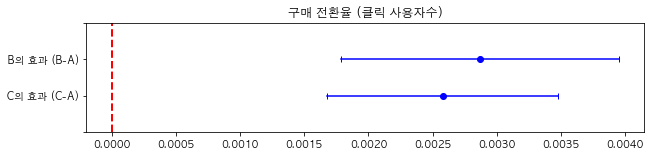

      category     lower      mean     upper
1  C의 효과 (C-A) -0.002859  0.002940  0.008739
0  B의 효과 (B-A) -0.003616  0.003326  0.010268


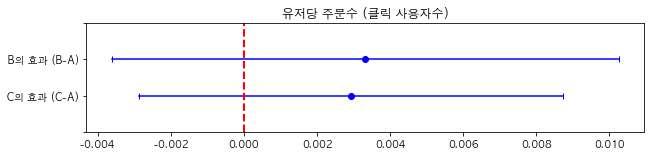

      category     lower      mean     upper
1  C의 효과 (C-A) -0.076183 -0.074499 -0.072816
0  B의 효과 (B-A) -0.101548 -0.099972 -0.098396


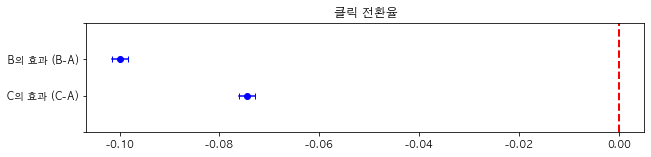

      category     lower      mean     upper
1  C의 효과 (C-A) -0.013145 -0.012083 -0.011022
0  B의 효과 (B-A)  0.001756  0.002892  0.004029


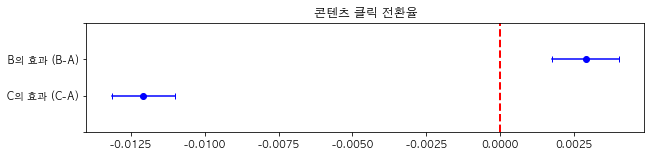

      category     lower      mean     upper
1  C의 효과 (C-A) -0.614447 -0.589978 -0.565510
0  B의 효과 (B-A) -0.681283 -0.657649 -0.634015


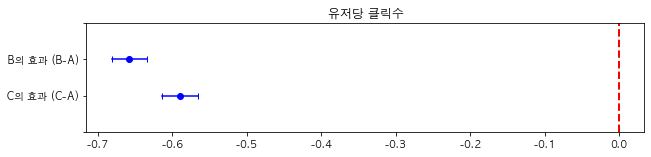

      category     lower      mean     upper
1  C의 효과 (C-A) -0.023342 -0.018821 -0.014299
0  B의 효과 (B-A)  0.000037  0.004593  0.009148


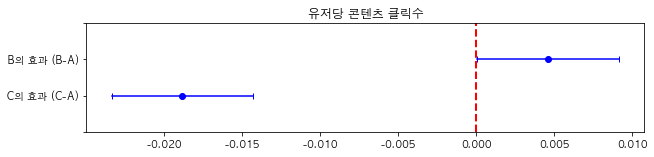

In [22]:
for idx in range(len(df)) : 
    if df.loc[idx,'지표 구분'] == 'conversion' : 
        conversion_inference(idx)
    elif df.loc[idx,'지표 구분'] == 'continuous' :
        continuous_inference(idx)
    else : 
        print('Error')
        break

In [23]:
df_result[['지표 정의','AB_mean','AB_P_value','AC_mean','AC_P_value']]

,지표 정의,AB_mean,AB_P_value,AC_mean,AC_P_value
0,구매 전환율,0.000030,0.4274,0.000111,0.0079
1,유저당 주문수,0.000051,0.9513,0.000137,0.8713
2,유저당 거래액,1.359023,0.9654,3.423041,0.9177
3,구매 전환율 (클릭 사용자수),0.002869,0.0000,0.002578,0.0000
4,유저당 주문수 (클릭 사용자수),0.003326,0.3477,0.002940,0.3204
5,클릭 전환율,-0.099972,0.0000,-0.074499,0.0000
6,콘텐츠 클릭 전환율,0.002892,0.0000,-0.012083,0.0000
7,유저당 클릭수,-0.657649,0.0000,-0.589978,0.0000
8,유저당 콘텐츠 클릭수,0.004593,0.0481,-0.018821,0.0000


In [298]:
df_result.to_excel('result.xlsx')

# Primary : 구매전환율

In [24]:
    z_score, pval , CI = two_mean_test(df.loc[idx,'A_분자']/df.loc[idx,'A_분모'],
                                       df.loc[idx,'A_분산'],
                                       df.loc[idx,'A_분모'],
                                       df.loc[idx,'B_분자']/df.loc[idx,'B_분모'],
                                       df.loc[idx,'B_분산'],
                                       df.loc[idx,'B_분모'])
    lower, mean , upper = CI 
    df_result.loc[idx,'AB_mean'] = mean
    df_result.loc[idx,'AB_Z_통계량'] = round(z_score,4)
    df_result.loc[idx,'AB_P_value'] = round(pval,4)
    df_result.loc[idx,'AB_CI_Lower'] = lower
    df_result.loc[idx,'AB_CI_Upper'] = upper
    z_score, pval , CI = two_mean_test(df.loc[idx,'A_분자']/df.loc[idx,'A_분모'],
                                       df.loc[idx,'A_분산'],
                                       df.loc[idx,'A_분모'],
                                       df.loc[idx,'C_분자']/df.loc[idx,'C_분모'],
                                       df.loc[idx,'C_분산'],
                                       df.loc[idx,'C_분모'])

In [25]:
df.loc[0,'A_분자']

49

In [26]:
df

,지표 구분,지표 정의,지표 상세,A_분자,B_분자,C_분자,A_분모,B_분모,C_분모,A_분산,B_분산,C_분산
0,conversion,구매 전환율,미식선물 컬렉션 구매자수 / 미식선물 컬렉션 노출 사용자수,49,59,78,272394,281384,268483,NaN,NaN,NaN
1,continuous,유저당 주문수,미식선물 컬렉션 주문수 / 미식선물 컬렉션 노출 사용자수,50,66,86,272394,281384,268483,2.041000e-02,1.753400e-01,1.711600e-01
2,continuous,유저당 거래액,미식선물 컬렉션 거래액 / 미식선물 컬렉션 노출 사용자수,1165100,1585960,2067400,272394,281384,268483,7.935969e+07,1.935180e+08,2.163052e+08
3,conversion,구매 전환율 (클릭 사용자수),미식선물 컬렉션 구매자수 / 미식선물 컬렉션 클릭 사용자수,49,59,78,41317,14550,20722,NaN,NaN,NaN
4,continuous,유저당 주문수 (클릭 사용자수),미식선물 컬렉션 주문수 / 미식선물 컬렉션 클릭 사용자수,50,66,86,41317,14550,20722,2.041000e-02,1.753400e-01,1.711600e-01
5,conversion,클릭 전환율,미식선물 컬렉션 클릭 사용자수 / 미식선물 컬렉션 노출 사용자수,41317,14550,20722,272394,281384,268483,NaN,NaN,NaN
6,conversion,콘텐츠 클릭 전환율,미식선물 컬렉션 콘텐츠 클릭 사용자수 / 미식선물 컬렉션 노출 사용자수,12941,14182,9511,272394,281384,268483,NaN,NaN,NaN
7,continuous,유저당 클릭수,미식선물 컬렉션 클릭수 / 미식선물 컬렉션 노출 사용자수,197581,19050,36345,272394,281384,268483,3.891315e+01,7.156700e-01,3.488940e+00
8,continuous,유저당 콘텐츠 클릭수,미식선물 컬렉션 콘텐츠 클릭수 / 미식선물 컬렉션 노출 사용자수,16714,18558,11421,272394,281384,268483,7.806000e-01,7.137500e-01,6.595600e-01


# 검산

In [41]:
from statsmodels.stats import proportion

In [42]:
def conversion_check(idx) : 
    lower , uppper = statsmodels.stats.proportion.confint_proportions_2indep(df.loc[idx,'B_분자'],df.loc[idx,'B_분모'],df.loc[idx,'A_분자'],df.loc[idx,'A_분모'])
    print(lower, upper)
conversion_check(0)

-4.4852390617716636e-05 0.00914843150119874


In [43]:
def conversion_check(idx) : 
    lower , uppper = statsmodels.stats.proportion.confint_proportions_2indep(df.loc[idx,'B_분자'],df.loc[idx,'B_분모'],df.loc[idx,'A_분자'],df.loc[idx,'A_분모'])
    print(lower, upper)
conversion_check(0)

-4.4852390617716636e-05 0.00914843150119874


In [44]:
def check_conver(idx) :
    zscore, pvalue = two_proprotions_test(df.loc[idx,'B_분자'],df.loc[idx,'B_분모'],df.loc[idx,'A_분자'],df.loc[idx,'A_분모'])
    print(f'BA pvalue : {pvalue}')
    zscore, pvalue = two_proprotions_test(df.loc[idx,'C_분자'],df.loc[idx,'C_분모'],df.loc[idx,'A_분자'],df.loc[idx,'A_분모'])
    print(f'CA pvalue : {pvalue}')
check_conver(6)

BA pvalue : 6.162931684983164e-07
CA pvalue : 0.0


In [45]:
def check_conti(idx) : 
   k = scipy.stats.ttest_ind_from_stats(df.loc[idx,'B_분자']/df.loc[idx,'B_분모'],np.sqrt(df.loc[idx,'B_분산']),df.loc[idx,'B_분모'],df.loc[idx,'A_분자']/df.loc[idx,'A_분모'],np.sqrt(df.loc[idx,'A_분산']),df.loc[idx,'A_분모'], equal_var=False)
   print(f'BA pvalue : {k.pvalue}')
   k = scipy.stats.ttest_ind_from_stats(df.loc[idx,'C_분자']/df.loc[idx,'C_분모'],np.sqrt(df.loc[idx,'C_분산']),df.loc[idx,'C_분모'],df.loc[idx,'A_분자']/df.loc[idx,'A_분모'],np.sqrt(df.loc[idx,'A_분산']),df.loc[idx,'A_분모'], equal_var=False)
   print(f'CA pvalue : {k.pvalue}')
check_conti(8)

BA pvalue : 0.04814774566691906
CA pvalue : 3.4132547499408206e-16


In [46]:
check_conti(1)

BA pvalue : 0.9513290341750951
CA pvalue : 0.8712844997103991


In [328]:
df

,지표 구분,지표 정의,지표 상세,A_분자,B_분자,C_분자,A_분모,B_분모,C_분모,A_분산,B_분산,C_분산
0,conversion,구매 전환율,미식선물 컬렉션 구매자수 / 미식선물 컬렉션 노출 사용자수,49,59,78,272394,281384,268483,NaN,NaN,NaN
1,continuous,유저당 주문수,미식선물 컬렉션 주문수 / 미식선물 컬렉션 노출 사용자수,50,66,86,272394,281384,268483,2.041000e-02,1.753400e-01,1.711600e-01
2,continuous,유저당 거래액,미식선물 컬렉션 거래액 / 미식선물 컬렉션 노출 사용자수,1165100,1585960,2067400,272394,281384,268483,7.935969e+07,1.935180e+08,2.163052e+08
3,conversion,구매 전환율 (클릭 사용자수),미식선물 컬렉션 구매자수 / 미식선물 컬렉션 클릭 사용자수,49,59,78,41317,14550,20722,NaN,NaN,NaN
4,continuous,유저당 주문수 (클릭 사용자수),미식선물 컬렉션 주문수 / 미식선물 컬렉션 클릭 사용자수,50,66,86,41317,14550,20722,2.041000e-02,1.753400e-01,1.711600e-01
5,conversion,클릭 전환율,미식선물 컬렉션 클릭 사용자수 / 미식선물 컬렉션 노출 사용자수,41317,14550,20722,272394,281384,268483,NaN,NaN,NaN
6,conversion,콘텐츠 클릭 전환율,미식선물 컬렉션 콘텐츠 클릭 사용자수 / 미식선물 컬렉션 노출 사용자수,12941,14182,9511,272394,281384,268483,NaN,NaN,NaN
7,continuous,유저당 클릭수,미식선물 컬렉션 클릭수 / 미식선물 컬렉션 노출 사용자수,197581,19050,36345,272394,281384,268483,3.891315e+01,7.156700e-01,3.488940e+00
8,continuous,유저당 콘텐츠 클릭수,미식선물 컬렉션 콘텐츠 클릭수 / 미식선물 컬렉션 노출 사용자수,16714,18558,11421,272394,281384,268483,7.806000e-01,7.137500e-01,6.595600e-01


In [333]:
np.sqrt(2.041000e-02)

0.1428635712839351

In [317]:
df_result['AC_P_value']

0    0.0079
1    0.8713
2    0.9177
3    0.0000
4    0.3204
5    0.0000
6    0.0000
7    0.0000
8    0.0000
Name: AC_P_value, dtype: float64

      category     lower      mean     upper
1  C의 효과 (C-A) -0.076183 -0.074499 -0.072816
0  B의 효과 (B-A) -0.101548 -0.099972 -0.098396


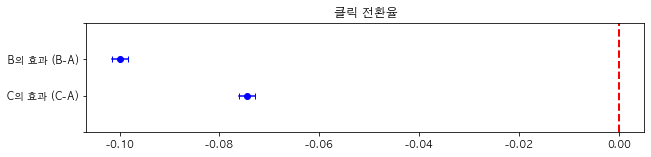

In [318]:
conversion_inference(5)

# Appendix

In [149]:
from matplotlib import pyplot as plt
data_dict = {}
data_dict['category'] = ['category 1','category 2','category 3']
data_dict['lower'] = [0.1,0.2,0.15]
data_dict['mean'] = [0.16,0.25,0.18]
data_dict['upper'] = [0.22,0.3,0.21]
dataset = pd.DataFrame(data_dict)
dataset

,category,lower,mean,upper
0,category 1,0.10,0.16,0.22
1,category 2,0.20,0.25,0.30
2,category 3,0.15,0.18,0.21


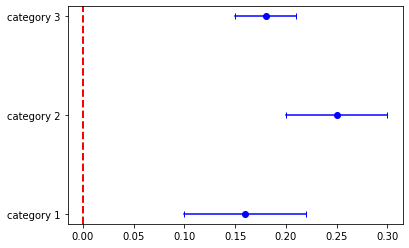

In [150]:
for lower,mean,upper,y in zip(dataset['lower'],
                              dataset['mean'],
                              dataset['upper'],
                              range(len(dataset))):
    # (lower , y) 와 (upper , y ) 를 잇는 선을 만들어냅니다. 즉 가로 수직선이 됩니다. 
    plt.plot((lower,upper),(y,y),'|-',color = 'blue')
    plt.plot(mean,y,'o',color = 'blue')
plt.yticks(range(len(dataset)),list(dataset['category']))

# 0 위치 표시하기 
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)

# Reterence

- http://ethen8181.github.io/machine-learning/ab_tests/frequentist_ab_test.html#Comparing-Two-Proportions